In [15]:
import sys
sys.path.insert(1, '/home/maria/Documents/EnsemblePursuit')
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, gaussian_filter1d

In [2]:
data_path='/home/maria/Documents/data_for_suite2p/TX39/'
dt=1
spks= np.load(data_path+'spks.npy')
print('Shape of the data matrix, neurons by timepoints:',spks.shape)
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
S = spks[:, iframe+dt]
print(S.shape)
#Uncomment to compute U and V
ep=EnsemblePursuit(n_components=200,lam=0.01,n_kmeans=200)
model=ep.fit(S.T[:10000,:])
V=model.components_
U=model.weights

Shape of the data matrix, neurons by timepoints: (18795, 30766)
(18795, 30560)
obtained 200 PCs in 15.4787 seconds
initialized 200 clusters with k-means in 43.2481 seconds
ensemble 0, time 33.66, nr neurons 6340, EV 0.0086
ensemble 25, time 174.70, nr neurons 206, EV 0.0329
ensemble 50, time 262.82, nr neurons 90, EV 0.0420
ensemble 75, time 340.15, nr neurons 95, EV 0.0492
ensemble 100, time 410.00, nr neurons 100, EV 0.0551
ensemble 125, time 475.23, nr neurons 80, EV 0.0605
ensemble 150, time 535.58, nr neurons 50, EV 0.0652
ensemble 175, time 591.61, nr neurons 46, EV 0.0695
ensemble 199, time 642.78, nr neurons 41, EV 0.0734
average sparsity is 0.0100


# Stimulus selectivity and spatial spread of ensembles

In [9]:
def train_test_split(NT):
        nsegs = 20
        nt=NT
        nlen  = nt/nsegs
        ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
        itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
        itrain = np.ones(nt, np.bool)
        itrain[itest] = 0
        return itrain, itest

Calculate receptive fields

In [16]:
mov=np.load(data_path+'mov.npy')
mov = mov[:, :, ivalid]
Sp = V.T
Sp = zscore(Sp, axis=1)
ly, lx, nstim = mov.shape
#print(nstim)
mov=mov[:,:,:NT]
NT = Sp.shape[1]
NN=Sp.shape[0]
print(NT)
itrain,itest=train_test_split(NT)

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = X-0.5 # subtract the background
X = np.abs(X) # does not matter if a pixel is black (0) or white (1)
X = zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = 0.1
ncomps = Sp.shape[0]
B0 = np.linalg.solve((X[:,itrain] @ X[:,itrain].T + lam * np.eye(npix)),  (X[:,itrain] @ Sp[:,itrain].T)) # get the receptive fields for each neuron

B0 = np.reshape(B0, (ly, lx, ncomps))
B0 = gaussian_filter(B0, [.5, .5, 0]) # smooth each receptive field a little


10000


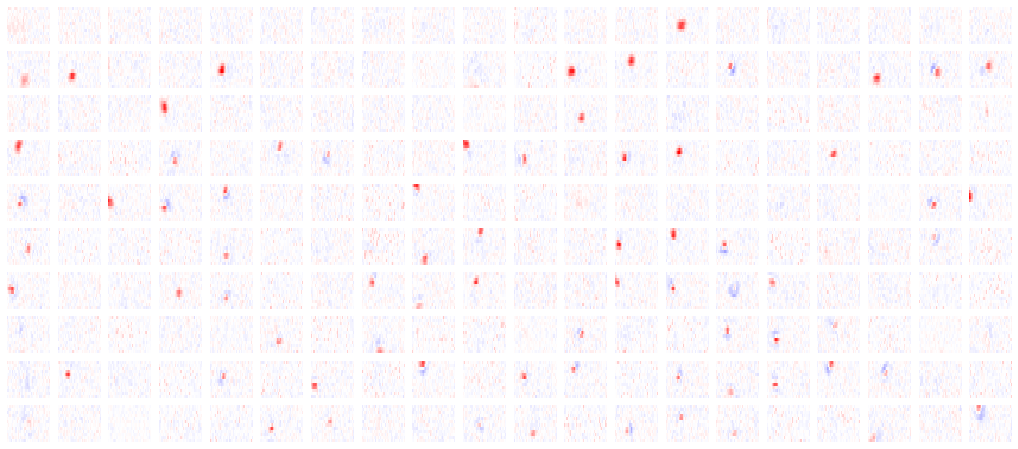

In [17]:
plt.figure(figsize=(18, 8))
rfmax = np.max(B0)
for j in range(200):
    plt.subplot(10,20,j+1)
    rf = B0[:,:,j]
    # rfmax = np.max(np.abs(rf))
    plt.imshow(rf, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax) # plot the receptive field for each neuron
    #plt.title('PC %d'%(1+j))
    plt.axis('off')

plt.show()

In [20]:
Spred = np.reshape(B0, (-1,NN)).T @  X[:,itest]

corr_lst=[]
nr_of_components=200
for j in range(0,nr_of_components):
    corr_lst.append(np.corrcoef(Sp[j,itest],Spred[j,:])[0,1])
#print(corr_lst)

In [22]:
stat = np.load((data_path+'stat.npy'), allow_pickle=True) # these are the per-neuron stats returned by suite2p
# these are the neurons' 2D coordinates
ypos = np.array([stat[n]['med'][0] for n in range(len(stat))]) 
# (notice the python list comprehension [X(n) for n in range(N)])
xpos = np.array([stat[n]['med'][1] for n in range(len(stat))]) 

In [24]:
print(ypos.shape)
print(U.shape)

(18795,)
(18795, 200)


(array([57., 22.,  5.,  5., 13., 36., 42., 18.,  1.,  1.]),
 array([ 47.45748251,  95.99051121, 144.5235399 , 193.05656859,
        241.58959728, 290.12262597, 338.65565466, 387.18868336,
        435.72171205, 484.25474074, 532.78776943]),
 <a list of 10 Patch objects>)

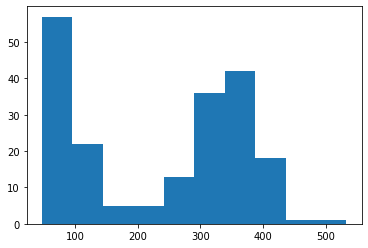

In [27]:
y_lst=[]
for comp in range(nr_of_components):
    nonz=np.nonzero(U[:,comp])[0]
    y_lst.append(np.std(ypos[nonz]))
plt.hist(y_lst)

(array([ 1., 36., 38.,  8.,  6., 11., 35., 40., 20.,  5.]),
 array([  3.60319208,  68.75083292, 133.89847375, 199.04611459,
        264.19375542, 329.34139626, 394.48903709, 459.63667793,
        524.78431876, 589.9319596 , 655.07960043]),
 <a list of 10 Patch objects>)

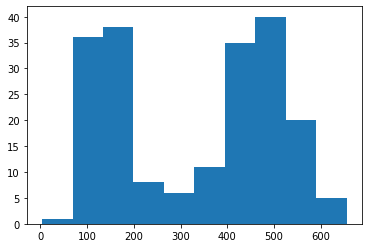

In [29]:
x_lst=[]
for comp in range(nr_of_components):
    nonz=np.nonzero(U[:,comp])[0]
    x_lst.append(np.std(xpos[nonz]))
plt.hist(x_lst)

Relationship between spatial spread and stimulus selectivity of ensembles. Stimulus ensembles are more spatially localized.

Text(0.5, 0, 'Average spatial spread in x and y directions')

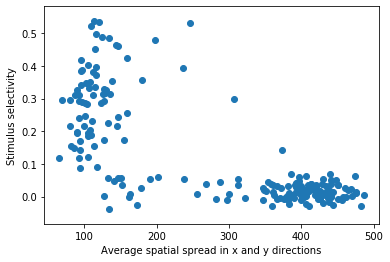

In [35]:
average_std=(np.array(x_lst)+np.array(y_lst))/2
plt.scatter(average_std,corr_lst)
plt.ylabel('Stimulus selectivity')
plt.xlabel('Average spatial spread in x and y directions')

# Behavior and spatial spread of ensembles

In [37]:
proc = np.load(data_path+'cam1_TX39_2019_05_31_1_proc_resampled.npy', allow_pickle=True).item()
motSVD = proc['motSVD'][:,iframe+dt]
motSVD -= motSVD.mean(axis=1)[:,np.newaxis]
beh=motSVD[:,:10000]
covM = np.matmul(beh[:,itrain], beh[:,itrain].T)
lam = 1e5 # regularizer
covM += lam*np.eye(beh.shape[0])
A = np.linalg.solve(covM, np.matmul(beh[:,itrain], V.T[:,itrain].T))
Vpred = np.matmul(A.T, beh[:,itest])
beh_corr_lst=[]
for j in range(0,nr_of_components):
    beh_corr_lst.append(np.corrcoef(Vpred[j,:],V.T[j,itest])[0,1])

Relationship between spatial spread and behavior selectivity of ensembles. Behavior ensembles are more spatially spread out.

Text(0.5, 0, 'Average spatial spread in x and y directions')

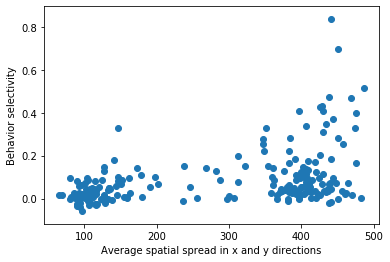

In [39]:
plt.scatter(average_std,beh_corr_lst)
plt.ylabel('Behavior selectivity')
plt.xlabel('Average spatial spread in x and y directions')

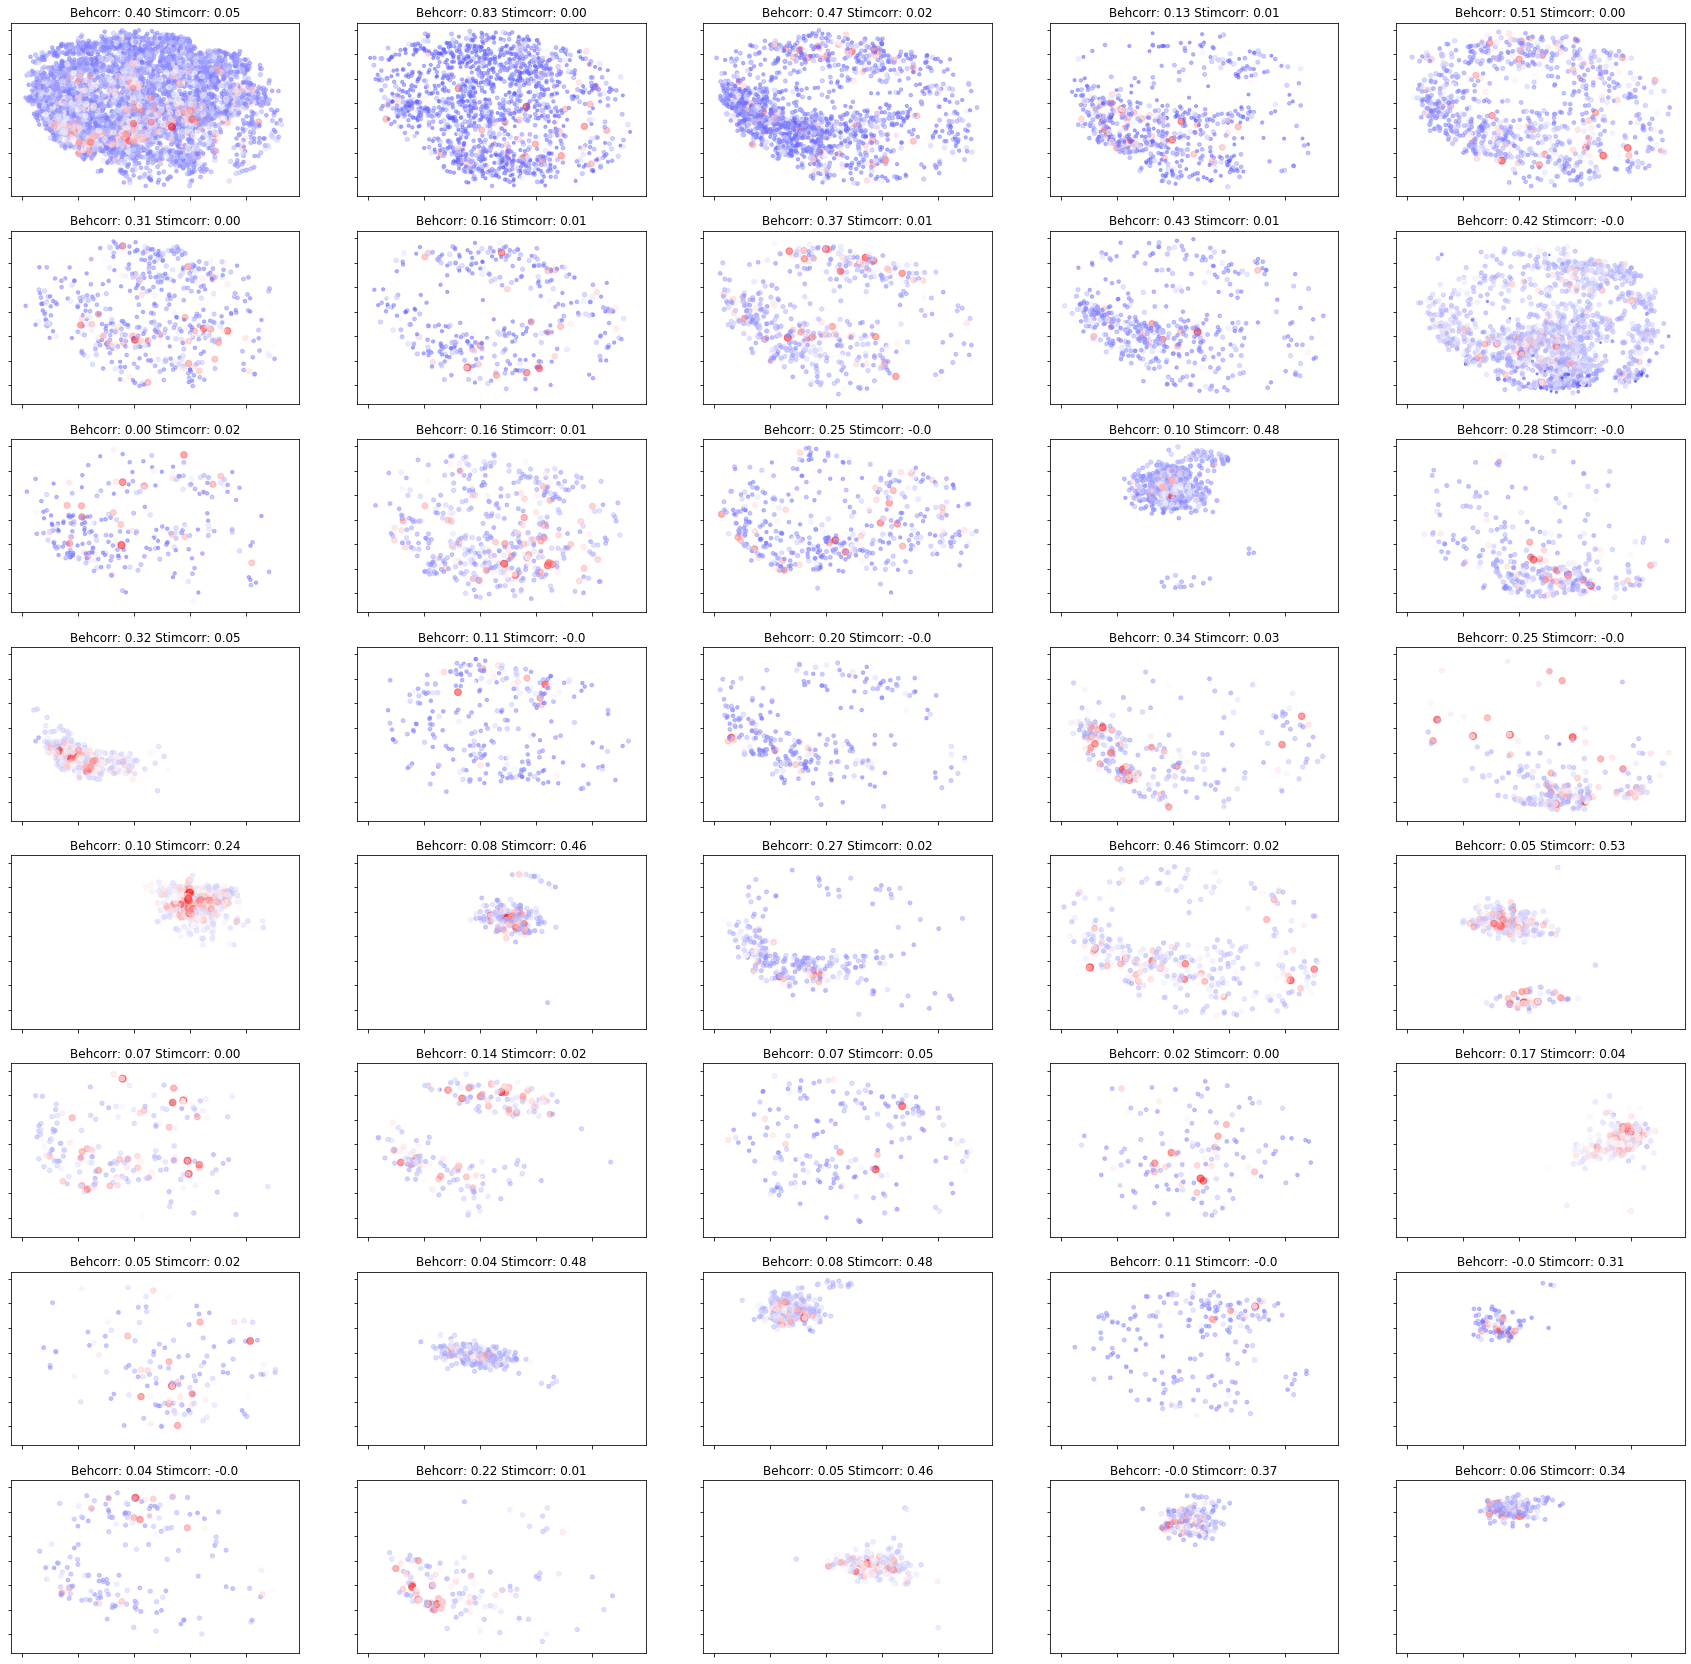

In [51]:
plt.figure(figsize=(30,30))
for j in range(40):
    comp= U[:,j]
    comp= comp/np.max(np.abs(comp))
    lam = np.abs(comp)    
    ax=plt.subplot(8,5,1+j)
    plt.scatter(xpos, -ypos, s = 50 * lam, c = comp, cmap='bwr', alpha = .5)
    plt.title('Behcorr: '+str(beh_corr_lst[j])[0:4]+' Stimcorr: '+str(corr_lst[j])[:4])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    #plt.colorbar()